<a href="https://colab.research.google.com/github/danialebrat/Comp_8740/blob/master/Assignment_3/Information_gain_Danial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install sklearn_evaluation

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, SelectPercentile, mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn_evaluation.plot import grid_search


In [5]:
# Constant variables

DATASET = "/content/drive/MyDrive/Dataset/COMP_8740/Breastcancer.csv"

PLOT_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP_8740/Assignmet3/Plots/"

RESULT_PATH = "/content/drive/MyDrive/Colab Notebooks/COMP_8740/Assignmet3/Results/"

In [45]:
class ML_Methods:

    def __init__(self, name, dataset):
        self.name = name
        self.dataset = dataset


    def preprocess(self, df):
        """
        create x and y from a pandas dataframe
        x, which are 2D point will be scaled using min-max scaler
        :param dataframe:
        :return (Scaled X (minmax), y):
        """

        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

        scaler = MinMaxScaler()
        x = scaler.fit_transform(X)

        return x, y

    def adding_methods(self):
        """
        adding all the methods with their specific names in a list
        :return: a List containing tuple of models (name of the model, model)
        """

        Models = []

        # models
        # Models.append(self.SVM_rbf())
        Models.append(self.Random_Forest())
        # Models.append(self.Deep_Neural_Network())

        return Models


    def Kfold_report(self, Models, x_train, y_train, dataset_name):
        """
        training all the models from the list of models using 10 fold cross validation
        :param x_train:
        :param y_train:
        :return:
        """

        print("**********")
        print("{} Dataset Results: ".format(dataset_name))

        results = []
        method_names = []
        for name, model in Models:
            # train the models
            KFold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
            CrossValidation = cross_val_score(model, x_train, y_train, cv=KFold, scoring='accuracy')
            results.append(CrossValidation)
            method_names.append(name)
            print(f"{name} Training Accuracy : {CrossValidation.mean()*100:.2f}%")

        return results, method_names


    def training_models(self, Models, x_train, x_test, y_train, y_test, datasetname):

        Results = []
        for name, model in Models:
            model.fit(x_train, y_train)
            predicted = model.predict(x_test)
            cm = confusion_matrix(y_test, predicted)
            AS = accuracy_score(y_test, predicted)

            Classifier, PPV, NPV, Sensitivity, Specificity, Testing_Accuracy = self.confusion_metrics(cm, AS, name, datasetname)

            Results.append([Classifier,
                            PPV,
                            NPV,
                            Sensitivity,
                            Specificity,
                            Testing_Accuracy])

        # Storing the result
        self.storing_results(Results, datasetname)


    def Random_Forest(self):
        """
        create a Random_Forest classifier
        :return (name of the mode, Random_Forest model):
        """
        name = "Random_Forest"
        RF_Model = RandomForestClassifier()
        return (name, RF_Model)

    
    def SVM_rbf(self):
      """
      create a SVM classifier
      :return (name of the mode, QDA model):
      """
      name = "SVM_rbf"
      SVM_rbf_model = SVC(kernel = 'rbf', random_state = 42)
      return(name, SVM_rbf_model)


    def Keras_Deep_Neural_Network(self):
        """
        create a Deep_Neural_Network classifier
        """

        DNN_model = Sequential()

        DNN_model.add(Dense(64, activation='relu', input_dim=204))
        DNN_model.add(Dropout(0.1))
        DNN_model.add(Dense(32, activation='relu'))
        DNN_model.add(Dropout(0.2))
        DNN_model.add(Dense(16, activation='relu'))
        DNN_model.add(Dropout(0.2))
        DNN_model.add(Dense(32, activation='relu'))
        DNN_model.add(Dropout(0.2))
        DNN_model.add(Dense(64, activation='relu'))
        DNN_model.add(Dropout(0.3))

        DNN_model.add(Dense(5, activation='softmax'))

        DNN_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return DNN_model


    def Deep_Neural_Network(self):
        """
        create a Deep_Neural_Network classifier
        :return (name of the mode, Deep_Neural_Network model):
        """
        name = "Deep_Neural_Network"

        # Wrap Keras model so it can be used by scikit-learn
        model = KerasClassifier(build_fn=self.Keras_Deep_Neural_Network,
                                epochs=20,
                                batch_size=16,
                                verbose=0)

        return (name, model)



    def data_spliting(self, x, y, test_size=0.2, random_state=42):
        """
        Split the data into x_train, x_test, y_train, y_test
        :param x: x (data)
        :param y: y (labels)
        :param test_size: size of test dataset
        :param random_state: 1 or 0
        :return: x_train, x_test, y_train, y_test
        """
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
        return x_train, x_test, y_train, y_test

    def plotting(self, results, names, dataset_name):

        plt.figure(figsize=(12, 10))
        boxplot = plt.boxplot(results, patch_artist=True, labels=names)


        # fill with colors
        colors = ['pink', 'lightblue', 'lightgreen', 'lime', 'grey']
        for box, color in zip(boxplot['boxes'], colors):
            box.set(color=color)

        title = "Classifiers Comparison _ {}".format(dataset_name)
        plt.title(title)

        # saving the plots
        fname = PLOT_PATH + title + ".png"
        plt.savefig(fname, dpi=100)
        plt.close('all')


    def confusion_metrics(self, cm, accuracy_score, method_name, dataset_name):

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
 
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        avg_PPV  = np.average(PPV, axis=None, weights=None, returned=False)
        avg_NPV  = np.average(NPV, axis=None, weights=None, returned=False)
        avg_TPR  = np.average(TPR, axis=None, weights=None, returned=False)
        avg_TNR  = np.average(TNR, axis=None, weights=None, returned=False)
        avg_ACC  = np.average(ACC, axis=None, weights=None, returned=False)

        # Accuracy for test set
        accuracy = round(accuracy_score*100, 2)

        print("**************")
        print("Classifier: {} _ Dataset: {}".format(method_name, dataset_name))
        print("PPV:{:.2f} | NPV:{:.2f} | Sensitivity:{:.2f} | Specificity:{:.2f} | Total_Accuracy:{:.2f}".format(avg_PPV, avg_NPV, avg_TPR, avg_TNR, avg_ACC))
        print("Accuracy Score for test_set: {:.2f} ".format(accuracy))

        return method_name, avg_PPV, avg_NPV, avg_TPR, avg_TNR, accuracy


    def storing_results(self, Results , dataset_name):
        """
        Storing the results in a csv file
        :return:
        """

        info = pd.DataFrame(Results, columns=['Classifier', 'PPV', 'NPV', 'Sensitivity', 'Specificity','Testing_Accuracy'])
        self.store(info, dest=RESULT_PATH, name=dataset_name)


    def store(self, df, dest, name):
        """
        Storing the results as an excel file in a folder
        :param dest:
        :param name:
        :return:
        """
        path = dest + name + ".xlsx"
        df.to_excel(path)

In [46]:
def read_csv(file):
  # read dataset csv as a Dataframe
  df = pd.read_csv(file)
  return df

In [78]:
def grid_search_tuning(Models, x_train, y_train):

  for name, model in Models:
    if name == "SVM_rbf":
      
      continue
      # C_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
      # gamma_range = [0.02,0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
      # degrees = range(3, 10)
      # parameters = dict(gamma=gamma_range, C=C_range, degree=degrees)

    else:
      parameters = {
          'max_features' : [7, 8, 9, 10, 12, 13],
          'n_estimators': [250, 300, 350, 400, 450, 500],
          }


    grid = GridSearchCV(model, parameters, refit = True, verbose = 0)
  
    # fitting the model for grid search
    grid.fit(x_train, y_train)


    gs = GridSearchCV(estimator = model,
                              param_grid = parameters,
                              scoring = 'accuracy',
                              cv = 10,
                              refit = True,
                              n_jobs = -1,
                              verbose = 0)
    
    gs.fit(x_train, y_train)

    results = pd.DataFrame(gs.cv_results_)
    display(results)

    grid_search(gs.cv_results_, change='max_features')
    plt.show()

    best_accuracy = gs.best_score_
    best_parameters = gs.best_params_

    print("{} Classifies: ***** ".format(name))
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

In [79]:
def feature_selection_Information_gain(x, y):

  scores = mutual_info_classif(x,y)
  
  # p_values = pd.Series(scores)
  # p_values.sort_values(ascending = False , inplace = True)
  # p_values.plot.bar()
  # plt.show()

  X_new = SelectPercentile(mutual_info_classif, percentile=1).fit_transform(x, y)

  return X_new


In [80]:
def feature_selection_ChiSquare(x, y):

  scores = chi2(x,y)
  
  # p_values = pd.Series(scores)
  # p_values.sort_values(ascending = False , inplace = True)
  # p_values.plot.bar()
  # plt.show()

  X_new = SelectPercentile(chi2, percentile=70).fit_transform(x, y)

  return X_new

Original number of features: (158, 13582)
Reduced number of features: (158, 96)
**********
Breast Cancer Dataset Results: 


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


Random_Forest Training Accuracy : 87.24%
**************
Classifier: Random_Forest _ Dataset: Breast Cancer
PPV:0.84 | NPV:0.97 | Sensitivity:0.88 | Specificity:0.97 | Total_Accuracy:0.95
Accuracy Score for test_set: 87.50 
******************************


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.591937,0.017445,0.046260,0.005457,7,250,"{'max_features': 7, 'n_estimators': 250}",0.769231,0.846154,0.923077,0.923077,0.923077,0.846154,0.75,0.916667,1.000000,0.833333,0.873077,0.073804,9
1,0.699852,0.017520,0.052870,0.001585,7,300,"{'max_features': 7, 'n_estimators': 300}",0.846154,0.769231,1.000000,1.000000,0.923077,0.769231,0.75,0.916667,1.000000,0.833333,0.880769,0.095476,3
2,0.810102,0.011763,0.063593,0.005858,7,350,"{'max_features': 7, 'n_estimators': 350}",0.846154,0.769231,1.000000,0.923077,0.923077,0.769231,0.75,0.916667,1.000000,0.750000,0.864744,0.095401,24
3,0.935931,0.011581,0.070276,0.002607,7,400,"{'max_features': 7, 'n_estimators': 400}",0.923077,0.769231,0.923077,1.000000,0.923077,0.769231,0.75,0.916667,1.000000,0.833333,0.880769,0.089063,3
4,1.042114,0.012556,0.079592,0.005098,7,450,"{'max_features': 7, 'n_estimators': 450}",0.846154,0.769231,1.000000,1.000000,0.923077,0.769231,0.75,0.916667,1.000000,0.833333,0.880769,0.095476,3
5,1.159430,0.015995,0.087570,0.002998,7,500,"{'max_features': 7, 'n_estimators': 500}",0.923077,0.769231,1.000000,0.923077,0.923077,0.846154,0.75,0.916667,1.000000,0.750000,0.880128,0.091064,8
6,0.586941,0.010723,0.044078,0.001365,8,250,"{'max_features': 8, 'n_estimators': 250}",0.923077,0.769231,0.923077,0.923077,0.923077,0.846154,0.75,0.916667,1.000000,0.750000,0.872436,0.083552,15
7,0.714026,0.021589,0.054775,0.004172,8,300,"{'max_features': 8, 'n_estimators': 300}",0.769231,0.769231,1.000000,0.923077,0.923077,0.846154,0.75,0.916667,0.916667,0.833333,0.864744,0.079521,24
8,0.830452,0.011814,0.066262,0.011771,8,350,"{'max_features': 8, 'n_estimators': 350}",0.846154,0.769231,0.923077,1.000000,0.923077,0.769231,0.75,0.916667,1.000000,0.833333,0.873077,0.088396,9
9,0.950566,0.021602,0.069221,0.002092,8,400,"{'max_features': 8, 'n_estimators': 400}",0.923077,0.769231,1.000000,0.923077,0.923077,0.769231,0.75,0.916667,0.916667,0.833333,0.872436,0.081056,15


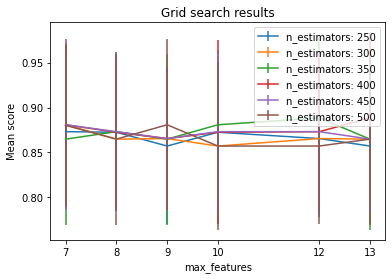

Random_Forest Classifies: ***** 
Best Accuracy: 88.85 %
Best Parameters: {'max_features': 12, 'n_estimators': 350}


In [81]:
if __name__ == "__main__":

    name = "Breast Cancer"

    # reading the data
    Data = read_csv(DATASET)
    
    # creating and ML_method object for the dataset
    method = ML_Methods(name="BreastCancer", dataset=Data)
    X, y = method.preprocess(Data)

    # Applying feature selection
    x_filtering  = feature_selection_ChiSquare(X, y)
    x  = feature_selection_Information_gain(x_filtering, y)

    print('Original number of features:', X.shape)
    print('Reduced number of features:', x.shape)

    

    # spliting the dataset
    x_train, x_test, y_train, y_test = method.data_spliting(x, y)

    # Adding methods:
    Models = method.adding_methods()

    # train the models and getting the results
    results, method_name = method.Kfold_report(Models, x_train, y_train, name)

    method.plotting(results, method_name, name)

    method.training_models(Models, x_train, x_test, y_train, y_test, name)


    print("******************************")


    grid_search_tuning(Models, x_train, y_train)


